In [3]:
import os
import shutil
import re
from fnmatch import fnmatch
import logging
from pathlib import Path
import csv
import pandas as pd
import numpy as np


In [17]:
csv_path1 = "../dataset/csv/label_test_A.csv"
csv_path2 = "../dataset/csv/label_test_B.csv"
csv_path3 = "../dataset/csv/label_test_C.csv"
csv_path4 = "../dataset/csv/label_test_D.csv"

# origins = "../dataset/test"


In [18]:

label = pd.read_csv(csv_path3)


In [19]:
label['label'].value_counts()

1    47
0    15
Name: label, dtype: int64

/opt/conda/envs/lancet/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2437


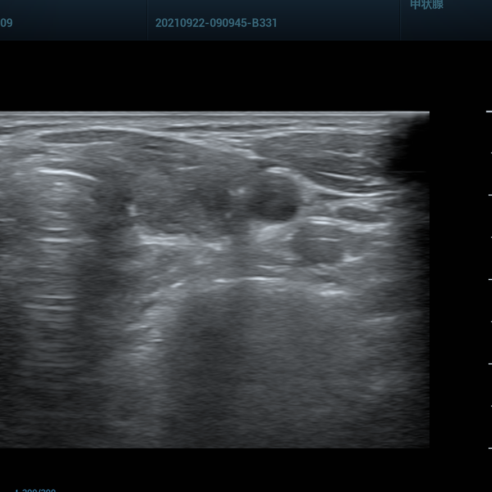

In [13]:
from importlib.resources import path
from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms
path_list = os.listdir("../dataset/origin/")
import random
x = int(random.random() *14000)
print(x)
img = Image.open(os.path.join("../dataset/origin", path_list[x]))
transform1 = transforms.Resize(512)
img = transform1(img)
# img.show()
transform = transforms.CenterCrop((492, 492))
transform2 = transforms.RandomHorizontalFlip(0.5)
img = transform(img)
img.show()

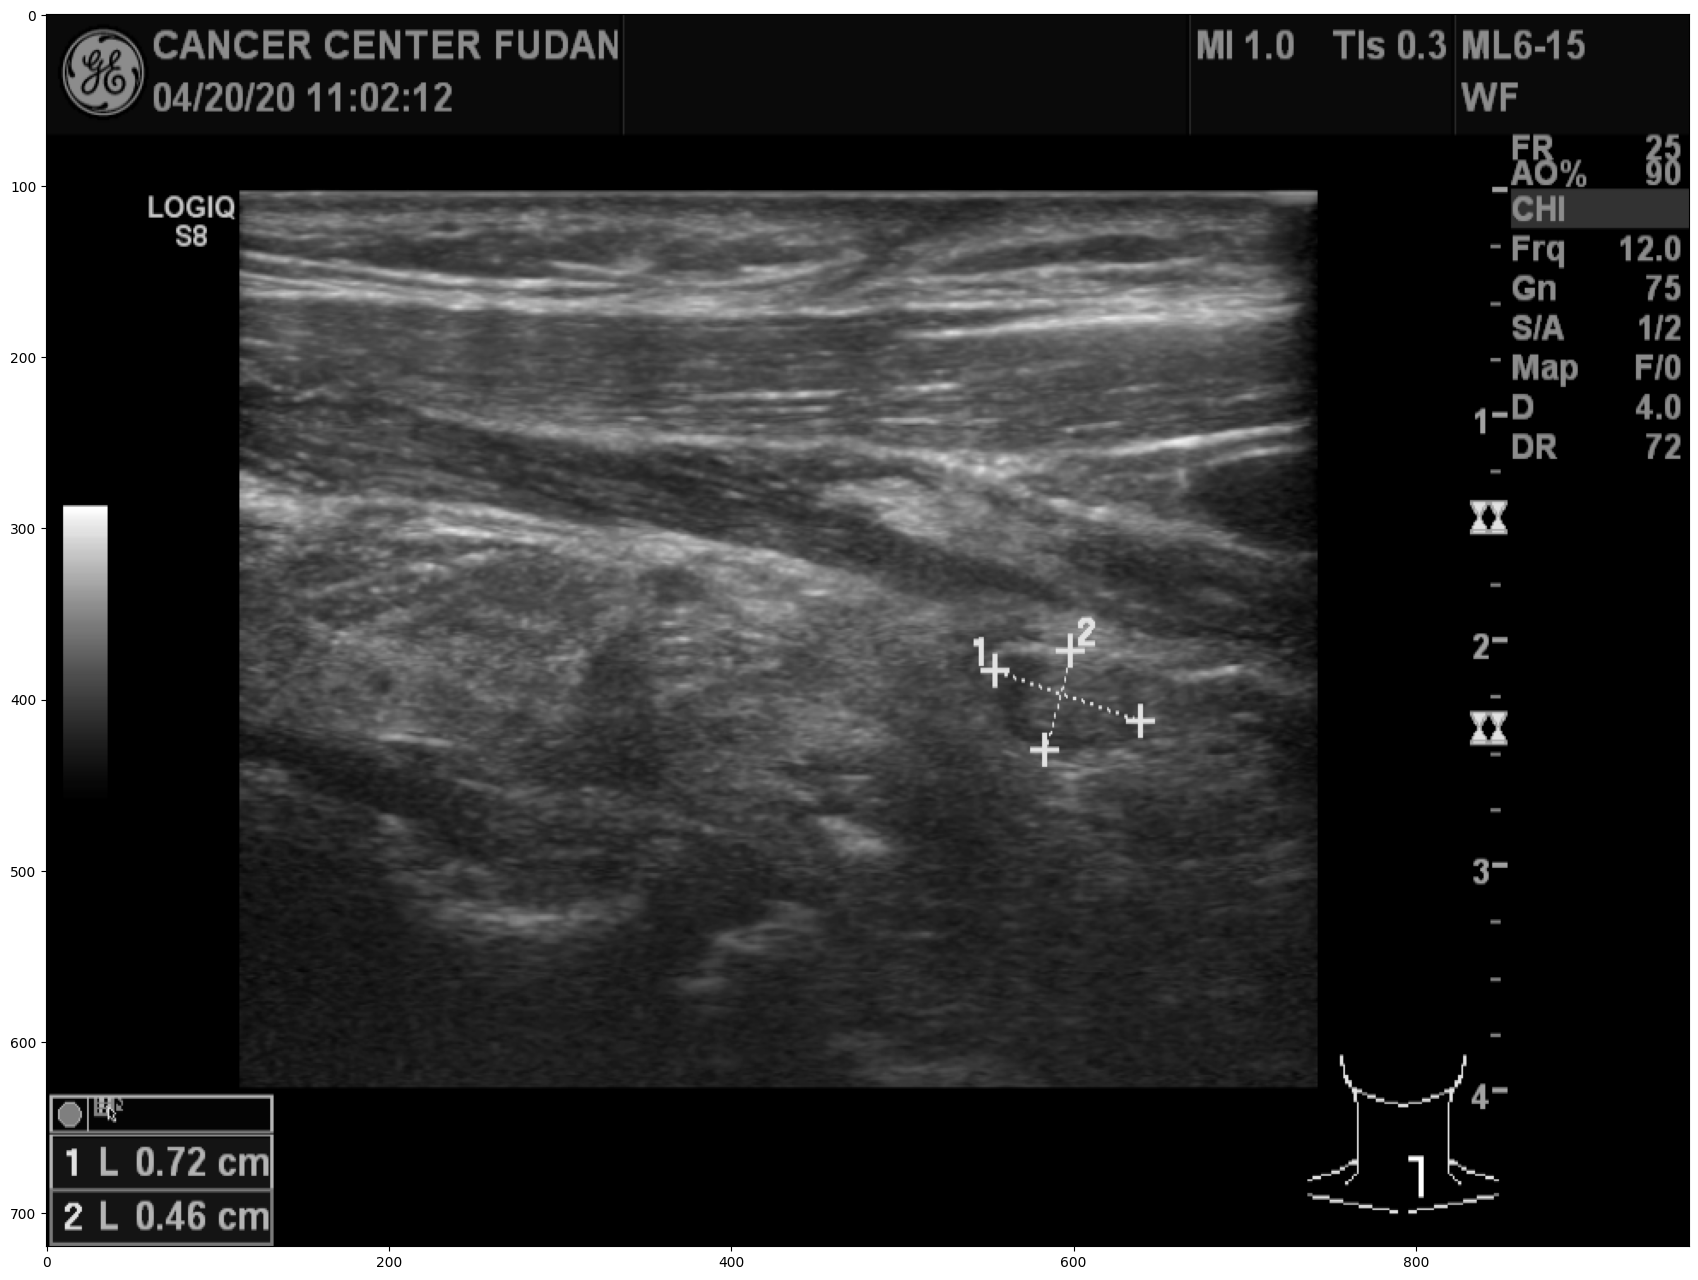

In [35]:
import cv2
import matplotlib.pyplot  as plt
# IMG_SIZE=512
fig = plt.figure(figsize=(25, 16))
image = cv2.imread(sample_path[1])
image = crop_image(image)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
# image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , IMG_SIZE/10) ,-4 ,128)
plt.imshow(image,cmap='gray')

In [18]:
%pip install opencv-python
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 9.8 MB/s eta 0:00:00:00:010:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 60.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 60.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
a = label.iloc[:,1].value_counts()

In [34]:
def crop_image1(img, tol=7):
    mask = img>tol
    return img[np.ix_(mask.any(1), mask.any(0))]
    
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image>1)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

def autocrop(image, threshold=0):
    """Crops any edges below or equal to threshold

    Crops blank image to 1x1.

    Returns cropped image.

    """
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image

def crop_image4(image):
    _,thresh = cv2.threshold(image,1,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(cnt)
    crop = image[y:y+h,x:x+w]
    return crop

def crop_image3(image):
    mask = image > 0

    # Coordinates of non-black pixels.
    coords = np.argwhere(mask)

    # Bounding box of non-black pixels.
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1   # slices are exclusive at the top
    
    # Get the contents of the bounding box.
    cropped = image[x0:x1, y0:y1]
    return cropped

def crop_image(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        h,w,_=img.shape
#         print(h,w)
        img1=cv2.resize(crop_image1(img[:,:,0]),(w,h))
        img2=cv2.resize(crop_image1(img[:,:,1]),(w,h))
        img3=cv2.resize(crop_image1(img[:,:,2]),(w,h))
        
#         print(img1.shape,img2.shape,img3.shape)
        img[:,:,0]=img1
        img[:,:,1]=img2
        img[:,:,2]=img3
        return img
    
def crop_image2(image,threshold=5):
    if len(image.shape) == 3:
        flatImage = np.max(image, 2)
    else:
        flatImage = image
    assert len(flatImage.shape) == 2

    rows = np.where(np.max(flatImage, 0) > threshold)[0]
    if rows.size:
        cols = np.where(np.max(flatImage, 1) > threshold)[0]
        image = image[cols[0]: cols[-1] + 1, rows[0]: rows[-1] + 1]
    else:
        image = image[:1, :1]

    return image


In [37]:
"""author:youngkun;date:20180608;function:裁剪照片的黑边"""

import cv2
import os
import datetime

def change_size(read_file):
    image=cv2.imread(read_file,1) #读取图片 image_name应该是变量

    b=cv2.threshold(image,15,255,cv2.THRESH_BINARY)          #调整裁剪效果
    binary_image=b[1]               #二值图--具有三通道
    binary_image=cv2.cvtColor(binary_image,cv2.COLOR_BGR2GRAY)
    print(binary_image.shape)       #改为单通道

    x=binary_image.shape[0]
    print("高度x=",x)
    y=binary_image.shape[1]
    print("宽度y=",y)
    edges_x=[]
    edges_y=[]

    for i in range(x):

        for j in range(y):

            if binary_image[i][j]==255:
             # print("横坐标",i)
             # print("纵坐标",j)
             edges_x.append(i)
             edges_y.append(j)

    left=min(edges_x)               #左边界
    right=max(edges_x)              #右边界
    width=right-left                #宽度

    bottom=min(edges_y)             #底部
    top=max(edges_y)                #顶部
    height=top-bottom               #高度

    pre1_picture=image[left:left+width,bottom:bottom+height]        #图片截取

    return pre1_picture                                             #返回图片数据

source_path="./1/"                                    #图片来源路径
save_path="./"                                     #图片修改后的保存路径

if not os.path.exists(save_path):
    os.mkdir(save_path)

file_names=os.listdir(source_path)

starttime=datetime.datetime.now()
for i in range(len(file_names)):
    x=change_size(source_path + file_names[i])        #得到文件名
    cv2.imwrite(save_path+file_names[i],x)
    print("裁剪：",file_names[i])
    print("裁剪数量:",i)
    while(i==2600):
        break


print("裁剪完毕")
endtime = datetime.datetime.now()#记录结束时间
endtime = (endtime-starttime).seconds
print("裁剪总用时",endtime)


(1080, 1920)
高度x= 1080
宽度y= 1920
裁剪： D0001-6R-UM-P1_1-01-T.jpg
裁剪数量: 0
(768, 1024)
高度x= 768
宽度y= 1024
裁剪： A06074-3R-UN-P2-3-01-N.bmp
裁剪数量: 1
裁剪完毕
裁剪总用时 5


In [34]:
import cv2
import os,numpy as np
import time

def  cut_pic(file_name):
    
    img = cv2.imread(file_name)  
    # b=cv2.threshold(img,15,255,cv2.THRESH_BINARY)          #调整裁剪效果
    # binary_image=b[1]               #二值图--具有三通道
    # binary_image=cv2.cvtColor(binary_image,cv2.COLOR_BGR2GRAY) 
    h, w, _ = img.shape
 
    GrayImage = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) #图片灰度化处理
    ret,binary = cv2.threshold(GrayImage,15,255,cv2.THRESH_BINARY) #图片二值化,灰度值大于40赋值255，反之0
    threshold = 1   #噪点阈值
    contours,hierarch=cv2.findContours(binary,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

# 填充彩图，再次转化为二值图进行其他操作,麻烦
    '''
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i]) #计算轮廓所占面积
        if area < threshold:                         #将area小于阈值区域填充背景色
            cv2.drawContours(img,[contours[i]],-1, (0,0,0), thickness=-1)     #原始图片背景BGR值(0,0,0)
            continue
    
    binary_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)                 #转为灰度图
    _, binary_image = cv2.threshold(binary, 15, 255, cv2.THRESH_BINARY)          #二值化
    '''
# 直接填充二值图
    for i in range(len(contours)):
        area = cv2.contourArea(contours[i])          #计算轮廓所占面积
        if area < threshold:                         #将area小于阈值区域填充背景色
            cv2.drawContours(binary, [contours[i]],-1, 0, thickness=-1)     #原始图片背景0
            continue

    print(binary.shape,end=' ')
#得到所有目标点 横坐标、纵坐标
    edges_x,edges_y = np.where(binary==255)

    top = min(edges_x)                 #上边界
    bottom = max(edges_x)              #下边界
    height=  bottom  - top             #高度

    left = min(edges_y)             	#左边界
    right = max(edges_y)                #右边界
    width = right - left                #宽度
    print((height,width))
#返回剪切后的图
    return img[top:top+height,left:left+width]


In [35]:
source_path="."                                    #图片来源路径
                                  #图片修改后的保存路径
starttime=time.time()
for i in range(1,2):
    print("裁剪：",str(i) + '.png',end=' ')
    img = cut_pic('./1/A06074-3R-UN-P2-3-01-N.bmp' )        #得到文件名
    save_path="./"   
    if not os.path.exists(save_path):
        os.mkdir(save_path)
    cv2.imwrite(save_path + '/A06074-3R-UN-P2-3-01-N.bmp',img)
    if i % 50 == 0:
        print("+++++++裁剪数量:",i,'++++++++')
print("裁剪完毕")
endtime = time.time()#记录结束时间
print("裁剪总用时%d s" % (endtime-starttime))


裁剪： 1.png (768, 1024) (699, 1023)
裁剪完毕
裁剪总用时0 s
